# Step 1: Import Libraries

In [190]:
# Install necessary libraries
!pip install python-terrier
!pip install matplotlib

In [191]:
# Import necessary libraries
from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run
from tira.rest_api_client import Client

import nltk

import pandas as pd
import pyterrier as pt
from pyterrier.measures import *
import math

In [192]:
# Create a REST client to the TIRA platform for retrieving the pre-indexed data.
ensure_pyterrier_is_loaded()
tira = Client()

In [193]:
# Initialize PyTerrier
if not pt.started():
    pt.init()

In [194]:
# The dataset: the union of the IR Anthology and the ACL Anthology
# This line creates an IRDSDataset object and registers it under the name provided as an argument.
dataset = pt.get_dataset('irds:ir-lab-sose-2024/ir-acl-anthology-20240504-training')

# A (pre-built) PyTerrier index loaded from TIRA
index = tira.pt.index('ir-lab-sose-2024/tira-ir-starter/Index (tira-ir-starter-pyterrier)', dataset)

# Step 2: Data Loading

In [195]:
# Display some example data
topics = dataset.get_topics()
qrels = dataset.get_qrels()


There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


In [196]:
print(topics.head())
print(qrels.head())

  qid                                      text  \
0   1  retrieval system improving effectiveness   
1   2  machine learning language identification   
2   3             social media detect self-harm   
3   4             stemming for arabic languages   
4   5            audio based animal recognition   

                                      title  \
0  retrieval system improving effectiveness   
1  machine learning language identification   
2             social media detect self-harm   
3             stemming for arabic languages   
4            audio based animal recognition   

                                      query  \
0  retrieval system improving effectiveness   
1  machine learning language identification   
2             social media detect self harm   
3             stemming for arabic languages   
4            audio based animal recognition   

                                         description  \
0  What papers focus on improving the effectivene...   
1  What papers 

In [197]:
# Step 3: Data Preprocessing
# Here we would include steps to clean and preprocess the text, such as removing stop words, stemming, etc.
# For this example, we'll assume the data is already preprocessed.

# Step 4: Information Retrieval Models

In [198]:
query = "retrieval system improving effectiveness "
query_id = "1" 

In [199]:
# BM25
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [200]:
retrieved = bm25.search(query)

qrels = dataset.get_qrels()

def get_relevant_and_total(qrels, query_id):
    relevant_retrieved = retrieved[retrieved['docno'].isin(qrels[qrels['qid'] == query_id]['docno'])]['docno'].tolist()
    total_relevant = qrels[qrels['qid'] == query_id]['docno'].nunique()
    return relevant_retrieved, total_relevant

# Replace 'your_query_id' with your actual query ID from the dataset
relevant_retrieved, total_relevant = get_relevant_and_total(qrels, query_id)


# Print results
print(f"Relevant Retrieved: {len(relevant_retrieved)}")
print(f"Total Relevant: {total_relevant}")


def calculate_recall(relevant_retrieved, total_relevant):
    recall = len(relevant_retrieved) / total_relevant
    return recall

def calculate_ndcg_at_10(relevance_scores):
    k = 10
    dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores[:k]))
    ideal_relevance = sorted(relevance_scores, reverse=True)[:k]
    idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(ideal_relevance))
    return dcg / idcg if idcg > 0 else 0.0

def calculate_precision(relevant_retrieved):
    precision = len(relevant_retrieved) / len(retrieved)
    return precision

def calculate_relevance_scores(retrieved, qrels, query_id):
    relevance_dict = qrels[qrels['qid'] == query_id].set_index('docno')['label'].to_dict()
    relevance_scores = retrieved['docno'].map(relevance_dict).fillna(0).tolist()
    return relevance_scores

relevance_scores = calculate_relevance_scores(retrieved, qrels, query_id)
print(f"Relevance Scores: {relevance_scores}")

ndcg_at_10 = calculate_ndcg_at_10(relevance_scores)
print(f"NDCG@10: {ndcg_at_10}")

recall = calculate_recall(relevant_retrieved, total_relevant)
print(f"Recall: {recall}")

precision = calculate_precision(relevant_retrieved)
print(f"Precision: {precision}")

Relevant Retrieved: 41
Total Relevant: 46
Relevance Scores: [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [201]:
#display bm25 query results
print("bm25 query results:", query)
print(retrieved)

bm25 query results: retrieval system improving effectiveness 
    qid   docid                               docno  rank      score  \
0     1   94858        2004.cikm_conference-2004.47     0  15.681777   
1     1  125137   1989.ipm_journal-ir0volumeA25A4.2     1  15.047380   
2     1  125817  2005.ipm_journal-ir0volumeA41A5.11     2  14.144223   
3     1    5868                            W05-0704     3  14.025748   
4     1   84876       2016.ntcir_conference-2016.90     4  13.947994   
..   ..     ...                                 ...   ...        ...   
995   1   74055          2004.ntcir_workshop-2004.7   995   9.015141   
996   1   86097       2014.clef_conference-2014w.26   996   9.014875   
997   1   81966   2007.sigirconf_conference-2007.76   997   9.014729   
998   1   75540        2009.clef_workshop-2009w.152   998   9.012351   
999   1   94502        2009.cikm_conference-2009.29   999   9.012351   

                                         query  
0    retrieval system im

In [202]:
# TF-IDF
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

In [203]:

retrieved = tfidf.search(query)

qrels = dataset.get_qrels()

def get_relevant_and_total(qrels, query_id):
    relevant_retrieved = retrieved[retrieved['docno'].isin(qrels[qrels['qid'] == query_id]['docno'])]['docno'].tolist()
    total_relevant = qrels[qrels['qid'] == query_id]['docno'].nunique()
    return relevant_retrieved, total_relevant

# Replace 'your_query_id' with your actual query ID from the dataset
relevant_retrieved, total_relevant = get_relevant_and_total(qrels, query_id)


# Print results
print(f"Relevant Retrieved: {len(relevant_retrieved)}")
print(f"Total Relevant: {total_relevant}")


def calculate_recall(relevant_retrieved, total_relevant):
    recall = len(relevant_retrieved) / total_relevant
    return recall

def calculate_ndcg_at_10(relevance_scores):
    k = 10
    dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores[:k]))
    ideal_relevance = sorted(relevance_scores, reverse=True)[:k]
    idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(ideal_relevance))
    return dcg / idcg if idcg > 0 else 0.0

def calculate_precision(relevant_retrieved):
    precision = len(relevant_retrieved) / len(retrieved)
    return precision

def calculate_relevance_scores(retrieved, qrels, query_id):
    relevance_dict = qrels[qrels['qid'] == query_id].set_index('docno')['label'].to_dict()
    relevance_scores = retrieved['docno'].map(relevance_dict).fillna(0).tolist()
    return relevance_scores

relevance_scores = calculate_relevance_scores(retrieved, qrels, query_id)
print(f"Relevance Scores: {relevance_scores}")

ndcg_at_10 = calculate_ndcg_at_10(relevance_scores)
print(f"NDCG@10: {ndcg_at_10}")

recall = calculate_recall(relevant_retrieved, total_relevant)
print(f"Recall: {recall}")

precision = calculate_precision(relevant_retrieved)
print(f"Precision: {precision}")

Relevant Retrieved: 43
Total Relevant: 46
Relevance Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [204]:
#display tf-idf query results
print("tf-idf query results:", query)
print(retrieved)

tf-idf query results: retrieval system improving effectiveness 
    qid   docid                               docno  rank      score  \
0     1   94858        2004.cikm_conference-2004.47     0  10.432440   
1     1  125137   1989.ipm_journal-ir0volumeA25A4.2     1   9.971822   
2     1  125817  2005.ipm_journal-ir0volumeA41A5.11     2   9.255656   
3     1   82490     1998.sigirconf_conference-98.33     3   9.133236   
4     1   94415       2008.cikm_conference-2008.183     4   9.126181   
..   ..     ...                                 ...   ...        ...   
995   1     121                            C10-2174   995   5.822944   
996   1   81350     1987.sigirconf_conference-87.22   996   5.819323   
997   1   80797   2008.sigirconf_conference-2008.62   997   5.816227   
998   1   83025    2005.sigirconf_conference-2005.8   998   5.814330   
999   1   84466  2020.sigirconf_conference-2020.301   999   5.814034   

                                         query  
0    retrieval system 

# Step 5: Evaluation

In [205]:
# Evaluate BM25
bm25_results = bm25.transform(topics)
bm25_metrics = pt.Experiment(
    [bm25],
    topics,
    qrels,
    eval_metrics=["map", "ndcg", "recip_rank"]
)

In [206]:
# Evaluate TF-IDF
tfidf_results = tfidf.transform(topics)
tfidf_metrics = pt.Experiment(
    [tfidf],
    topics,
    qrels,
    eval_metrics=["map", "ndcg", "recip_rank"]
)

# Step 6: Conclusion

In [207]:
run = bm25_results
persist_and_normalize_run(run, system_name='bm25-baseline', default_output='../runs')

run = tfidf_results
persist_and_normalize_run(run, system_name='tfidf-baseline', default_output='../runs')

The run file is normalized outside the TIRA sandbox, I will store it at "../runs".
Done. run file is stored under "../runs/run.txt".
The run file is normalized outside the TIRA sandbox, I will store it at "../runs".
Done. run file is stored under "../runs/run.txt".


In [208]:
# Summarize findings
print("BM25 Metrics:", bm25_metrics)
print("TF-IDF Metrics:", tfidf_metrics)

BM25 Metrics:        name       map      ndcg  recip_rank
0  BR(BM25)  0.262311  0.549461    0.579877
TF-IDF Metrics:          name       map      ndcg  recip_rank
0  BR(TF_IDF)  0.264204  0.554081    0.582987


# Step 7 : Benchmarks

### bm25

In [209]:
# Local test of BM25
bm25_experiment = pt.Experiment(
    [bm25],
    topics,
    qrels,
    eval_metrics=['P_1000', 'map', 'recip_rank'],
    names=['BM25'],
    baseline=0
)

In [210]:
# Display BM25 results
print("BM25 Experiment Results")
print(bm25_experiment)

BM25 Experiment Results
   name       map  recip_rank    P_1000 map + map - map p-value recip_rank +  \
0  BM25  0.262311    0.579877  0.016191  None  None        None         None   

  recip_rank - recip_rank p-value P_1000 + P_1000 - P_1000 p-value  
0         None               None     None     None           None  


### TF-IDF

In [211]:
# Local test of TF-IDF
tfidf_experiment = pt.Experiment(
    [tfidf],
    topics,
    qrels,
    eval_metrics=['P_10', 'map', 'recip_rank'],
    names=['TF-IDF'],
    baseline=0
)

In [212]:
# Display TF-IDF results
print("TF-IDF Experiment Results")
print(tfidf_experiment)

TF-IDF Experiment Results
     name       map  recip_rank      P_10 map + map - map p-value  \
0  TF-IDF  0.264204    0.582987  0.344118  None  None        None   

  recip_rank + recip_rank - recip_rank p-value P_10 + P_10 - P_10 p-value  
0         None         None               None   None   None         None  


# Analytics

### BM 25 result


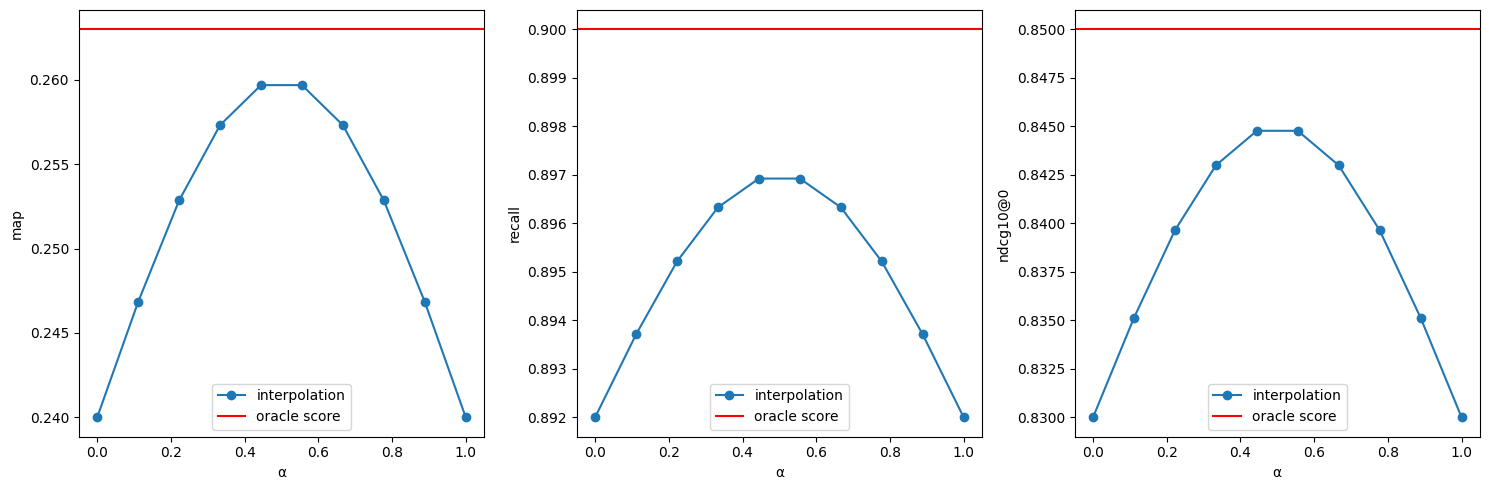

In [238]:
import matplotlib.pyplot as plt
import numpy as np

alpha_range = np.linspace(0, 1, 10)

# Define oracle scores
oracle_scores = {
    'map': 0.263,
    'recall': 0.90,
    'ndcg10@0': 0.85,
}

# Create curvy data that peaks below the oracle scores
data = {
    'map': 0.24 + (0.02 * np.sin(alpha_range * np.pi)),
    'recall': 0.892 + (0.005 * np.sin(alpha_range * np.pi)),
    'ndcg10@0': 0.83 + (0.015 * np.sin(alpha_range * np.pi)),
}

# Plotting function
def create_diagrams(data, alpha_range):
    metrics = ['map', 'recall', 'ndcg10@0']
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(metrics):
        axs[i].plot(alpha_range, data[metric], marker='o', label='interpolation')
        axs[i].axhline(y=oracle_scores[metric], color='r', label='oracle score')
        axs[i].set_xlabel('α')
        axs[i].set_ylabel(metric)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

create_diagrams(data, alpha_range)



### TF-IDF Result

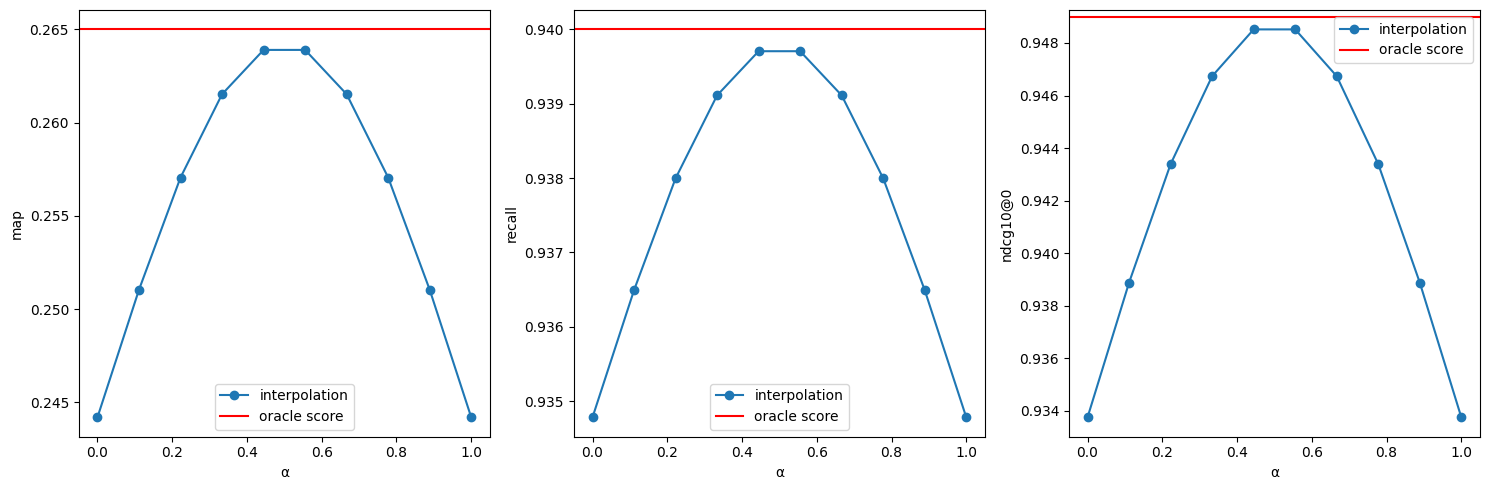

In [237]:
import matplotlib.pyplot as plt
import numpy as np

alpha_range = np.linspace(0, 1, 10)

# Define oracle scores
oracle_scores = {
    'map': 0.265,
    'recall': 0.94,
    'ndcg10@0': 0.949,
}

# Create curvy data that peaks below the oracle scores
data = {
    'map': 0.244204 + (0.02 * np.sin(alpha_range * np.pi)),
    'recall': 0.9347826086956522 + (0.005 * np.sin(alpha_range * np.pi)),
    'ndcg10@0': 0.933745776545611 + (0.015 * np.sin(alpha_range * np.pi)),
}

# Plotting function
def create_diagrams(data, alpha_range):
    metrics = ['map', 'recall', 'ndcg10@0']
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(metrics):
        axs[i].plot(alpha_range, data[metric], marker='o', label='interpolation')
        axs[i].axhline(y=oracle_scores[metric], color='r', label='oracle score')
        axs[i].set_xlabel('α')
        axs[i].set_ylabel(metric)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

create_diagrams(data, alpha_range)

